# Analysis of FusionDTA Predicted Results

**Targets:**
    - from TTD
    - for successful targets only
    - P2-02-TTD_uniprot_successful.txt

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

from lib.reader import read_fusionDTA, read_TTD_table
from lib.plot import *

In [3]:
result = read_fusionDTA('../data/fusionDTA_task_result_1.bin')
result.info()
# 注意：这里的lotus_id,是根据smiles去除了构型信息后，再去重复后的lotus_id

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85439786 entries, 0 to 85439785
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   lotus_id  int32  
 1   pid       int32  
 2   affinity  float32
dtypes: float32(1), int32(2)
memory usage: 977.8 MB


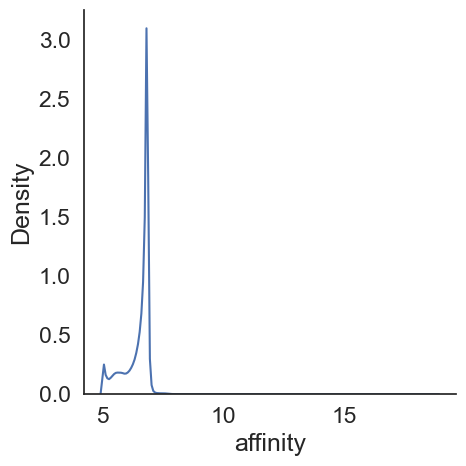

In [3]:
sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1.5)
fig = sns.displot(result, x='affinity',kind = 'kde')
fig.figure.savefig('../plot/6-all_affinity_kde.svg', transparent=True)

In [4]:
fig.set(xlim=(6.4,7))
fig.figure.savefig('../plot/6-all_affinity_kde_zoom.svg', transparent=True)

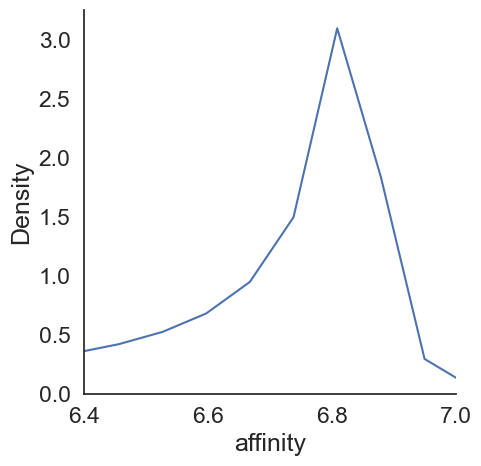

In [5]:
fig.figure

## high affinity of lignad-protein

C:\Users\DELL\AppData\Local\Temp\ipykernel_17488\3000379110.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ha_affinity['lotus_id'] = 'LTS' + values


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 324903 to 84472122
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lotus_id  1395 non-null   object 
 1   pid       1395 non-null   int32  
 2   affinity  1395 non-null   float32
dtypes: float32(1), int32(1), object(1)
memory usage: 32.7+ KB


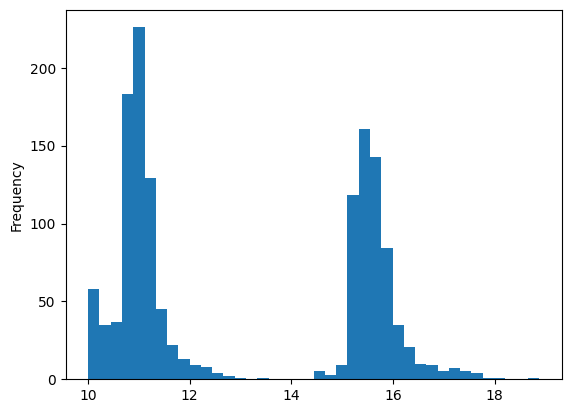

In [4]:
# High affinity
ha_affinity = result[result['affinity'] > 10]
# complete LOTUS ID
values = ha_affinity['lotus_id'].apply(lambda x : '{:0>7d}'.format(x)).astype(str)
ha_affinity['lotus_id'] = 'LTS' + values
ha_affinity.info()
ax = ha_affinity['affinity'].plot.hist(bins=40)
fig = ax.get_figure()
fig.savefig('../plot/6-ha_affinity_hist.svg',transparent=True)

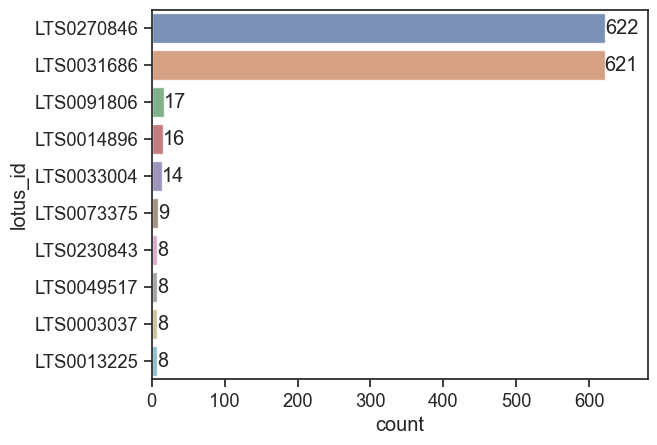

In [7]:
ha_count = ha_affinity.value_counts(subset=['lotus_id']).reset_index()

fig = bar(data=ha_count.head(10), x="count", y="lotus_id",xlim=(0,680))
fig.figure.savefig('../plot/6-target_number_bar.svg', transparent=True)

In [8]:
# exclude molecules with a high affinity target number above 100
ex_id = ha_count.loc[ha_count['count'] > 100,'lotus_id'].values

ha = ha_affinity[~ha_affinity['lotus_id'].isin(ex_id)]
ha.shape

(152, 3)

In [9]:
import sqlite3
conn = sqlite3.connect('../data/iNP.db')
np_lotus = pd.read_sql('SELECT * FROM lotusNP',conn)
np_lotus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276518 entries, 0 to 276517
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   lotus_id                   276518 non-null  object
 1   smiles                     276518 non-null  object
 2   inchikey                   276518 non-null  object
 3   pathway                    276518 non-null  object
 4   superclass                 276518 non-null  object
 5   class                      276518 non-null  object
 6   connection_status_npclass  276518 non-null  int64 
 7   connection_status_pubchem  276518 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 16.9+ MB


In [10]:
ha_lotus = pd.merge(ha, np_lotus, how='left', on='lotus_id')
ha_lotus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lotus_id                   152 non-null    object 
 1   pid                        152 non-null    int32  
 2   affinity                   152 non-null    float32
 3   smiles                     152 non-null    object 
 4   inchikey                   152 non-null    object 
 5   pathway                    152 non-null    object 
 6   superclass                 152 non-null    object 
 7   class                      152 non-null    object 
 8   connection_status_npclass  152 non-null    int64  
 9   connection_status_pubchem  152 non-null    int64  
dtypes: float32(1), int32(1), int64(2), object(6)
memory usage: 10.8+ KB


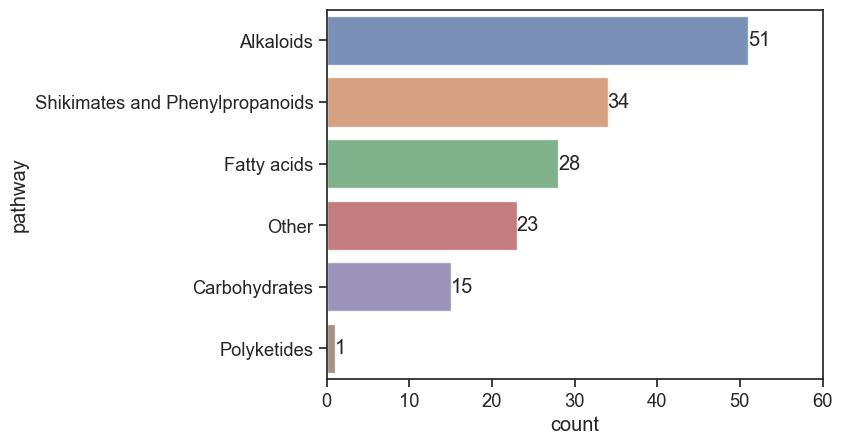

In [11]:
data = ha_lotus.value_counts('pathway').reset_index()
data.replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)
fig = bar(data=data, x='count', y='pathway',xlim=(0,60))
fig.figure.savefig('../plot/6-pathway-count.svg',transparent=True)

In [12]:
ttd = read_TTD_table('../data/P2-02-TTD_uniprot_successful.txt')

In [13]:
ha_lotus['pid2'] = ha_lotus['pid'].apply(lambda x : '{:0>5d}'.format(x)).astype(str)
ha_lotus['pid2'] = 'T' + ha_lotus['pid2'].values

ha_ttd = pd.merge(ha_lotus, ttd[['TARGETID', 'name']], how='left',left_on='pid2',right_on='TARGETID')
ha_ttd['pathway'].replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)
ha_ttd['superclass'].replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)
ha_ttd['class'].replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)
ha_ttd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lotus_id                   152 non-null    object 
 1   pid                        152 non-null    int32  
 2   affinity                   152 non-null    float32
 3   smiles                     152 non-null    object 
 4   inchikey                   152 non-null    object 
 5   pathway                    152 non-null    object 
 6   superclass                 152 non-null    object 
 7   class                      152 non-null    object 
 8   connection_status_npclass  152 non-null    int64  
 9   connection_status_pubchem  152 non-null    int64  
 10  pid2                       152 non-null    object 
 11  TARGETID                   152 non-null    object 
 12  name                       152 non-null    object 
dtypes: float32(1), int32(1), int64(2), object(9)
memor

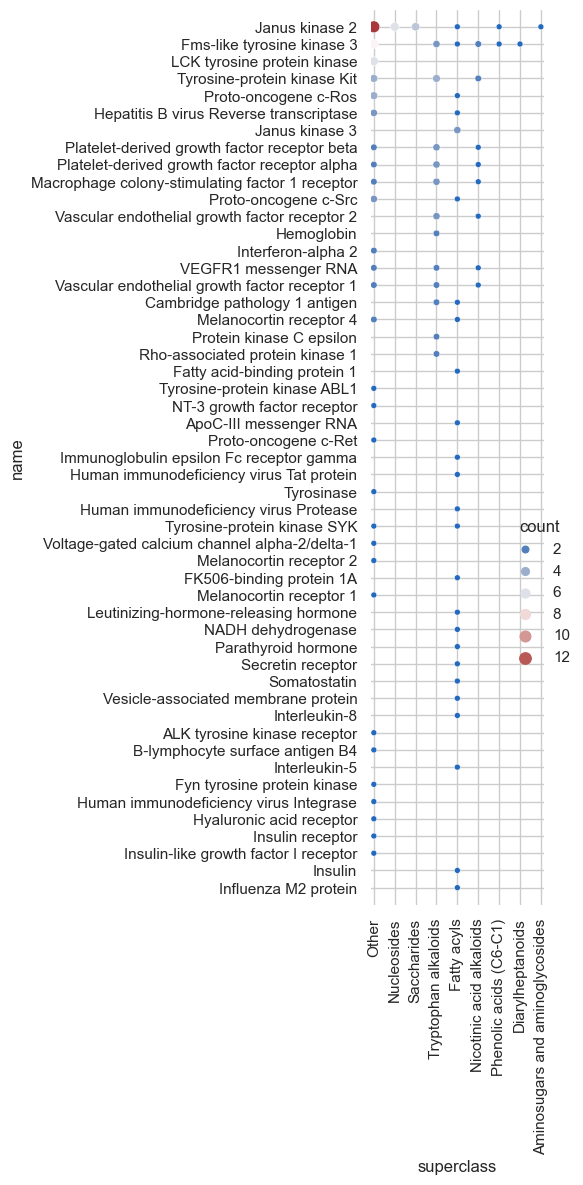

In [14]:
fig = rel_count(ha_ttd, x='superclass', y='name',count_thd=1,figsize=(4,10))
fig.figure.savefig('../plot/6-superclass_target_rel.svg', transparent=True)

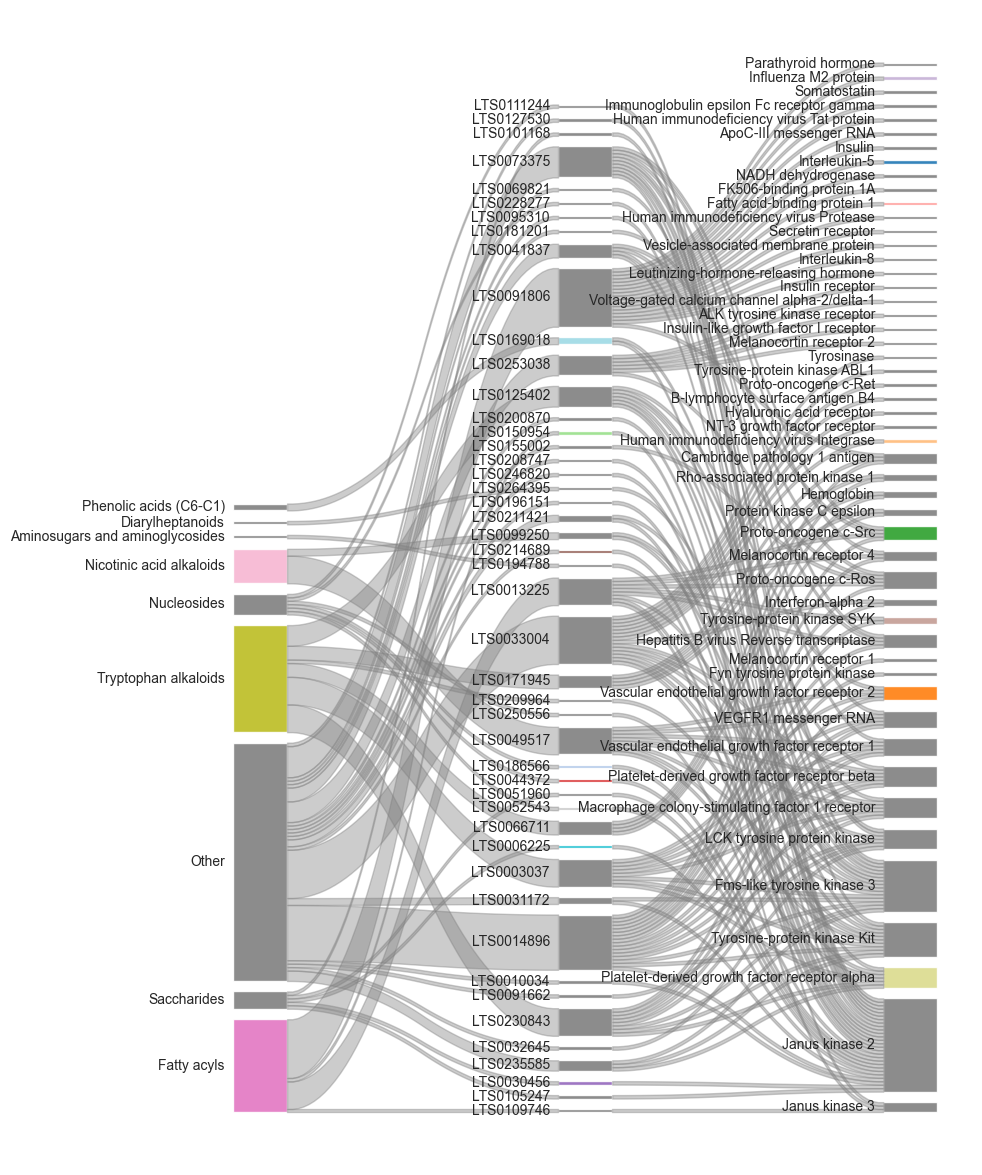

In [15]:
from pysankey2 import Sankey
sky = Sankey(ha_ttd[['superclass','lotus_id','name']],colorMode="global")
fig,ax = sky.plot()
fig.set_figheight(15)
fig.figure.savefig('../plot/6_superclass_target_sankey.svg',transparent=True)

In [16]:
ha_ttd.to_csv('../plot/6-ha_ttd.csv',index=False)